# Machine Learning LAB 2: SUPPORT VECTOR MACHINES

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks to be performed with **SUPPORT VECTOR MACHINES (SVM)**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Weather Classification with Support Vector Machines

In this notebook we are going to explore the use of Support Vector Machines (SVM) for weather classification. We will use a dataset collected using the Luxottica **iSee** glasses. These devices provide multiple **sensors mounted inside the glasses**, which can be accessed through a bluetooth connection.

![I-SEE Glasses](data/isee.png "I-SEE")

The dataset corresponds to 8 hours of atmospherical data recordings sampled every 3 seconds.

The dataset labels are the following:

| ID  | Label       |
| :-: | :-:         |
| 0   | Sunny       |
| 1   | Rain        |
| 2   | Cloudy      |
| 3   | Mostly Clear|

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB02.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Gabriele Poccianti

**ID Number**: 2106713

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import itertools
from matplotlib import pyplot as plt

import sklearn.metrics as skm
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.model_selection import train_test_split

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `load_dataset` -> to load the dataset from the file `data/lux.npz`,
2. `plot_input` -> to plot the input data,
3. `k_split` ->  to split the trainig dataset in k different folds,
4. `k_fold_cross_validation` -> to perform the k-fold cross validation.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
# Helper function to load the dataset
def load_dataset(path: str) -> (np.ndarray, np.ndarray):
    with np.load(path) as data:
        x, y = data["x"], data["y"]
        
        # Normalize the data
        x -= x.mean(axis=0)
        x /= x.std(axis=0)
        
    return x, y

In [3]:
# Function for plotting a image and printing the corresponding label
def plot_input(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.get_cmap('Accent', 4)
    im = ax.scatter(X_matrix[:,0], X_matrix[:,1], X_matrix[:,2], c=labels, cmap=cmap)
#    im = ax.scatter(X_matrix[:,0], X_matrix[:,1], X_matrix[:,2],c=cmap, cmap=cmap)
    im.set_clim(-0.5, 3.5)
    cbar=fig.colorbar(im, ticks=[0,1,2,3], orientation='vertical', cmap=cmap)
    cbar.ax.set_yticklabels(['Sunny', 'Rainy','Cloudy', 'Mostly clear']) 

In [4]:
# Function to split the dataset in k different folds
def k_split(x: np.ndarray, y:np.ndarray, k: int, shuffle: bool = True) -> tuple[list[np.ndarray], list[np.ndarray]]:
    # Shuffle the dataset
    if shuffle:
        # Create a list of indices
        idx = np.arange(x.shape[0])
        # Randomly shuffle the indices
        np.random.shuffle(idx)
        # Shuffle the dataset
        x = x[idx]
        y = y[idx]

    # Split the dataset in k folds
    # ADD YOUR CODE HERE
    m=X_train.shape[0]
    X,Y=[],[]
    for i in np.arange(k):
        idx = np.arange(i/k*m,(i+1)/k*m,dtype=int) #i-fold indexes
        X.append(x[idx,])
        Y.append(y[idx,])
    return(X,Y)

In [5]:
# Function to perform the k-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, model: SVC, parameters: dict) -> tuple[tuple, tuple]:
    # Define the folds for the cross validation
    x_folds, y_folds = k_split(x_train, y_train, k)
    n_v=np.array(x_folds).shape
    n=n_v[1]*n_v[2]

    # Build a list containing all of the possible combinations of parameters
    params = list(itertools.product(*parameters.values()))

    # Initialize the dictionary of results
    results = {k: 0 for k in params}

    # For each param combination, perform the SVM training and testing
    for param in params:
        param = dict(zip(parameters.keys(), param))
        model.set_params(**param)
        fold_accuracies = []
        acc=np.zeros(k)
        
        # ADD YOUR CODE HERE
        for i in np.arange(k):
            x_folds_new=np.array(x_folds)[np.arange(k)!=i].reshape(n,n_v[2]) #we select every fold except the i - th one
            y_folds_new=np.array(y_folds)[np.arange(k)!=i].reshape(n,)
            model.fit(x_folds_new,y_folds_new)
            acc[i] = model.score(x_folds[i],y_folds[i])
        fold_accuracies.append(acc)

        # Compute the mean accuracy
        results[tuple(param.values())] = round(np.mean(fold_accuracies), 4)
    
    # Find the best parameters
    best_parameters = dict(zip(parameters.keys(), params[np.argmax(list(results.values()))]))
    best_accuracy = np.max(list(results.values()))
    best = (best_parameters, best_accuracy)

    # Add the param name to the results
    results = [({k: v for k, v in zip(parameters.keys(), p)}, a) for p, a in results.items()]

    return best, results

---

## A) Hyper-parameter search

### TO DO (A.0)

**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [6]:
# fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2106713# YOUR ID
np.random.seed(ID)

Before proceding to the training steps, we **load the dataset and split it** in training and test set (while the **training** set is **typically larger**, here we set the number of training samples to 1000 and 4000 for the test data).
The **split** is **performed after applying a random permutation** to the dataset, such permutation will **depend on the seed** you set above.

In [7]:
# Load the dataset using the helper function
X, y = load_dataset("data/lux.npz")
print(X.shape, y.shape)

(15099, 3) (15099,)


In [8]:
# The task is quite easy, let's add noise to make it more challenging!
# You can try without noise (comment the next 2 lines, easy task), with the suggested amount of noise,
# or play with the suggested amount of noise 

noise = np.random.normal(0, 0.1, X.shape)
X = X + noise

### TO DO (A.1)

**Divide** the **data into training and test set** (for this part use 1000 samples in the **first** set, 4000 in the **second** one). Make sure that each label is present at least 10 times in training. If it is not, then keep adding permutations to the initial data until this happens.


In [9]:
# Random permute the data and split into training and test taking the first 1000
# data samples as training and 4000 samples as test
idx = np.arange(X.shape[0])
permutation = np.random.shuffle(idx) # ADD YOUR CODE HERE (replace None)

X = X[idx] # ADD YOUR CODE HERE (replace None)
y = y[idx] # ADD YOUR CODE HERE (replace None)

m_training = 1000
m_test = 4000

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=m_training,test_size=m_test) 

X_train = np.array(X_train) # ADD YOUR CODE HERE (replace None)
X_test = np.array(X_test) # ADD YOUR CODE HERE (replace None)
y_train = np.array(y_train) # ADD YOUR CODE HERE (replace None)
y_test = np.array(y_test) # ADD YOUR CODE HERE (replace None)

print("X_train shape:", X_train.shape,"X_test shape:", X_test.shape,"||","y_train shape:",  y_train.shape,"y_test shape:", y_test.shape)

labels, freqs = np.unique(y_train, return_counts=True) # ADD YOUR CODE HERE. Hint: use np.unique() (replace None)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

X_train shape: (1000, 3) X_test shape: (4000, 3) || y_train shape: (1000,) y_test shape: (4000,)
Labels in training dataset:  [0. 1. 2. 3.]
Frequencies in training dataset:  [432 152 346  70]


/var/folders/sq/hv1_dwz10cx9mcwy54fj3st40000gn/T/ipykernel_5212/1661122920.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Accent', 4)


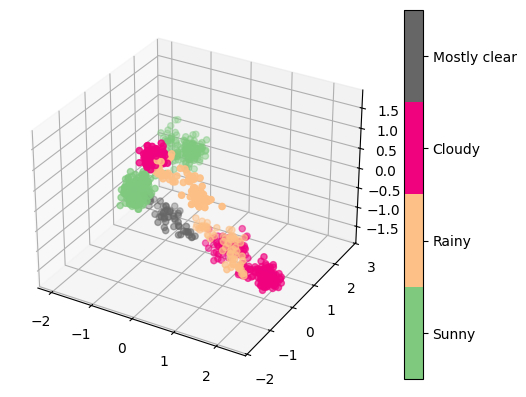

In [10]:
#Let's try the plotting function
plot_input(X_train,y_train)

### TO DO (A.2)

Use a SVM classfier with cross validation to pick a model. Use a 4-fold cross-validation. Let's start with a Linear kernel.

In [11]:
# Parameters for linear SVM
parameters = {'C': [ 0.01, 0.1, 1, 10]}

# Define the model (without parameters)
svm = SVC(kernel="linear") # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, 4, svm, parameters) # ADD YOUR CODE HERE (replace None)

print ('RESULTS FOR LINEAR KERNEL')

print("Best parameter set found:")
# ADD YOUR CODE HERE
print(best[0])

print("Score with best parameter:")
# ADD YOUR CODE HERE
print(best[1])

print("All scores on the grid:")
# ADD YOUR CODE HERE
print(results)

RESULTS FOR LINEAR KERNEL
Best parameter set found:
{'C': 1}
Score with best parameter:
0.915
All scores on the grid:
[({'C': 0.01}, np.float64(0.771)), ({'C': 0.1}, np.float64(0.891)), ({'C': 1}, np.float64(0.915)), ({'C': 10}, np.float64(0.915))]


### TO DO (A.3)

Pick a model for the Polynomial kernel with degree=2.

In [12]:
# Parameters for linear SVM
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1,1.]}

# Define an SVM with poly of degree 2 kernel (without parameters)
poly2_svm =  SVC(kernel="poly",degree=2)# ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best2, results2 = k_fold_cross_validation(X_train, y_train, 4, poly2_svm, parameters) # ADD YOUR CODE HERE (replace None)

print ('RESULTS FOR POLY DEGREE=2 KERNEL')

print("Best parameter set found:")
# ADD YOUR CODE HERE
print(best2[0])

print("Score with best parameter:")
# ADD YOUR CODE HERE
print(best2[1])

print("All scores on the grid:")
# ADD YOUR CODE HERE
print(results2)

RESULTS FOR POLY DEGREE=2 KERNEL
Best parameter set found:
{'C': 1, 'gamma': 1.0}
Score with best parameter:
0.957
All scores on the grid:
[({'C': 0.01, 'gamma': 0.01}, np.float64(0.432)), ({'C': 0.01, 'gamma': 0.1}, np.float64(0.432)), ({'C': 0.01, 'gamma': 1.0}, np.float64(0.844)), ({'C': 0.1, 'gamma': 0.01}, np.float64(0.432)), ({'C': 0.1, 'gamma': 0.1}, np.float64(0.757)), ({'C': 0.1, 'gamma': 1.0}, np.float64(0.942)), ({'C': 1, 'gamma': 0.01}, np.float64(0.432)), ({'C': 1, 'gamma': 0.1}, np.float64(0.844)), ({'C': 1, 'gamma': 1.0}, np.float64(0.957))]


### TO DO (A.4)

Now let's try a higher degree for the polynomial kernel (e.g., 3rd degree).

In [13]:
# Parameters for poly with higher degree kernel
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1, 1]}

# Define an SVM with poly of higher degree kernel (without parameters)
degree = 3
poly_svm = SVC(kernel="poly",degree=degree) # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best3, results3 = k_fold_cross_validation(X_train, y_train, 4, poly_svm, parameters) # ADD YOUR CODE HERE (replace None)

print (f"RESULTS FOR POLY DEGREE={degree} KERNEL")

print("Best parameter set found:")
# ADD YOUR CODE HERE
print(best3[0])

print("Score with best parameter:")
# ADD YOUR CODE HERE
print(best3[1])

print("All scores on the grid:")
# ADD YOUR CODE HERE
print(results3)

RESULTS FOR POLY DEGREE=3 KERNEL
Best parameter set found:
{'C': 1, 'gamma': 1}
Score with best parameter:
0.947
All scores on the grid:
[({'C': 0.01, 'gamma': 0.01}, np.float64(0.432)), ({'C': 0.01, 'gamma': 0.1}, np.float64(0.432)), ({'C': 0.01, 'gamma': 1}, np.float64(0.861)), ({'C': 0.1, 'gamma': 0.01}, np.float64(0.432)), ({'C': 0.1, 'gamma': 0.1}, np.float64(0.539)), ({'C': 0.1, 'gamma': 1}, np.float64(0.922)), ({'C': 1, 'gamma': 0.01}, np.float64(0.432)), ({'C': 1, 'gamma': 0.1}, np.float64(0.765)), ({'C': 1, 'gamma': 1}, np.float64(0.947))]


### TO DO (A.5)

Pick a model for the Radial Basis Function kernel:

In [14]:
# Parameters for rbf SVM
parameters = {'C': [0.1, 1, 10, 100],'gamma':[0.001, 0.01, 0.1,1]}

# Define an SVM with rbf kernel (without parameters)
rbf_svm = SVC(kernel="rbf") # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best_rbf, results_rbf = k_fold_cross_validation(X_train, y_train, 4, rbf_svm, parameters) # ADD YOUR CODE HERE (replace None)

print ('RESULTS FOR rbf KERNEL')

print("Best parameter set found:")
# ADD YOUR CODE HERE
print(best_rbf[0])

print("Score with best parameter:")
# ADD YOUR CODE HERE
print(best_rbf[1])

print("All scores on the grid:")
# ADD YOUR CODE HERE
print(results_rbf)

RESULTS FOR rbf KERNEL
Best parameter set found:
{'C': 10, 'gamma': 1}
Score with best parameter:
0.988
All scores on the grid:
[({'C': 0.1, 'gamma': 0.001}, np.float64(0.432)), ({'C': 0.1, 'gamma': 0.01}, np.float64(0.605)), ({'C': 0.1, 'gamma': 0.1}, np.float64(0.841)), ({'C': 0.1, 'gamma': 1}, np.float64(0.948)), ({'C': 1, 'gamma': 0.001}, np.float64(0.605)), ({'C': 1, 'gamma': 0.01}, np.float64(0.787)), ({'C': 1, 'gamma': 0.1}, np.float64(0.949)), ({'C': 1, 'gamma': 1}, np.float64(0.985)), ({'C': 10, 'gamma': 0.001}, np.float64(0.785)), ({'C': 10, 'gamma': 0.01}, np.float64(0.913)), ({'C': 10, 'gamma': 0.1}, np.float64(0.983)), ({'C': 10, 'gamma': 1}, np.float64(0.988)), ({'C': 100, 'gamma': 0.001}, np.float64(0.901)), ({'C': 100, 'gamma': 0.01}, np.float64(0.964)), ({'C': 100, 'gamma': 0.1}, np.float64(0.984)), ({'C': 100, 'gamma': 1}, np.float64(0.981))]


In [15]:
best_v=[best,best2,best3,best_rbf]
svm_v=[svm,poly2_svm,poly_svm,rbf_svm]

### TO DO (A.Q1) [Answer the following]

What do you observe when using RBF and polynomial kernels on this dataset ?

**ANSWER A.Q1:**: The kernel that yelds the best results is the rbf kernel with best parameters C=10, gamma=1.
The second best model is the polynomial with degree=2 (best parameters C=1, gamma=1), followed by poynomial with degree=3 (C=1, gamma=1).

We remind that C=1/lambda is the parameter which controls the width of the margins, while gamma controls the "smoothness" of the margins.
We can interpret our results as follows:
the polynomial kernels yeld almost the same accuracy (there is no net improvement in increasing the degree, on the other hand the second degree polynomial method is more accurate).
The rbf kernel obtains the most accurate result, with the same smoothness of the other methods and tighter margins.
We could than infere that this kernel is the best, but we don't know yet how these results generalize to the test set.

### TO DO (A.6)
Report here the best SVM kernel and parameters

In [16]:
# Get training and test error for the best SVM model from CV
best_idx= np.argmax([best[1],best2[1],best3[1],best_rbf[1]])
best_svm = svm_v[best_idx] # USE YOUR OPTIMAL PARAMETERS HERE (replace None)
best_svm.set_params(**best_v[best_idx][0])

# Run the svm model on the whole training set
best_svm.fit(X_train,y_train)

# Compute the errors
# (error is 1 - svm.score)
training_error = 1-best_svm.score(X_train,y_train) # ADD YOUR CODE (replace None)
test_error = 1-best_svm.score(X_test,y_test) # ADD YOUR CODE (replace None)

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

Best SVM training error: 0.012000
Best SVM test error: 0.013250


### TO DO (A.7)

Analyze how the gamma parameter (inversely proportional to standard deviation of Gaussian Kernel) impact the performances of the classifier

In [17]:
# Test with different values of gamma
# use rbf kernel and C=1
rbf_svm = SVC(kernel="rbf")
rbf_svm.set_params(C=1)

# Set gamma values
gamma_values = np.logspace(-5,2,8)
print(gamma_values)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


In [18]:
train_acc_list, test_acc_list = [], []

# ADD YOUR CODE TO TRAIN THE SVM MULTIPLE TIMES WITH THE DIFFERENT VALUES OF GAMMA
# PLACE THE TRAIN AND TEST ACCURACY FOR EACH TEST IN THE TRAIN AND TEST ACCURACY LISTS
for gamma in gamma_values:
    rbf_svm.set_params(gamma=gamma)
    rbf_svm.fit(X_train,y_train)
    y_predict_train=rbf_svm.predict(X_train)
    y_predict_test=rbf_svm.predict(X_test)
    train_acc_list.append(skm.accuracy_score(y_train, y_predict_train, normalize = True))
    test_acc_list.append(skm.accuracy_score(y_test,y_predict_test,normalize=True))

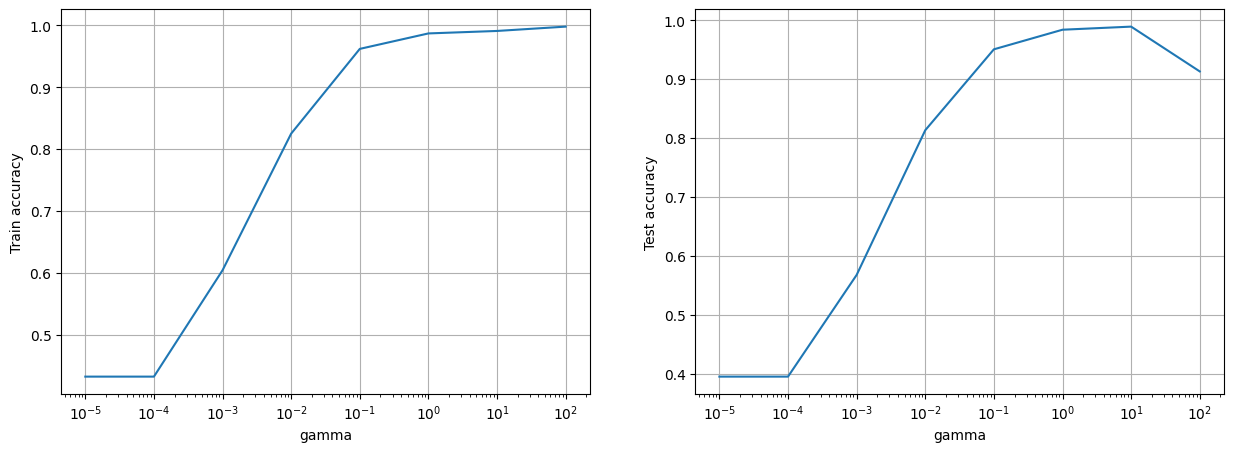

In [19]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(gamma_values, train_acc_list)
ax[0].set_xscale('log')
ax[0].set_xlabel('gamma')
ax[0].set_ylabel('Train accuracy')
ax[0].grid(True)

ax[1].plot(gamma_values, test_acc_list)
ax[1].set_xscale('log')
ax[1].set_xlabel('gamma')
ax[1].set_ylabel('Test accuracy')
ax[1].grid(True)

plt.show()

## B) More data
Now let's do the same but using more data points for training.

### TO DO (B.0)

Choose a higher number of data points (e.g. x = 10000) for training data depending on your computing capability.

In [20]:
idx = np.arange(X.shape[0])
permutation = np.random.shuffle(idx)
X = X[idx]
y = y[idx]

m_training = 1000 # ADD YOUR CODE: adjust depending on the capabilities of your PC (replace None)

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True) # ADD YOUR CODE (replace None)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

# initialize support variables for boundaries visualization
granularity = 25
x_max = np.abs(X).max()
x_range = np.linspace(-x_max, x_max, granularity)
x_grid = np.stack(np.meshgrid(x_range, x_range, x_range)).reshape(3, -1).T

Labels in training dataset:  [0. 1. 2. 3.]
Frequencies in training dataset:  [404 186 342  68]


### TO DO (B.1)

Let's try to use SVM with parameters obtained from the best model for $m_{training} =  10000$. Since it may take a long time to run, you can decide to just let it run for some time and stop it if it does not complete. If you decide to do this, report it in the TO DO (C.Q1) cell below.

In [21]:
# Get training and test error for the best SVM model from CV

# ADD YOUR CODE
best_svm.fit(X_train,y_train)
training_error = 1-best_svm.score(X_train,y_train)
test_error = 1-best_svm.score(X_test,y_test)

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

Best SVM training error: 0.007000
Best SVM test error: 0.011348


## C) Boundaries Visualization

Now let us plot the classification boundaries. 

### TO DO (C.0)

Use the SVM to predict on the test set X_test. 

In [22]:
# Compare rbf svm with logistic regression with and without regularization

rbf_svm_test = best_svm.predict(X_test) # ADD YOUR CODE (replace None)

# Let's now see the logistic regressions
# With regularization (I use the usual l2 loss here)
R_logreg = linear_model.LogisticRegression()
R_logreg.fit(X_train, y_train)
R_logreg_test = R_logreg.predict(X_test)

# Without regularization
NR_logreg = linear_model.LogisticRegression(penalty = None)
NR_logreg.fit(X_train, y_train)
NR_logreg_test = NR_logreg.predict(X_test)

We constructed a grid of all possible combinations of input values, we now use it to extract the classification boundaries of the three classifiers by having them predict on each input.

(-2.7127933284636088, 2.7127933284636088)

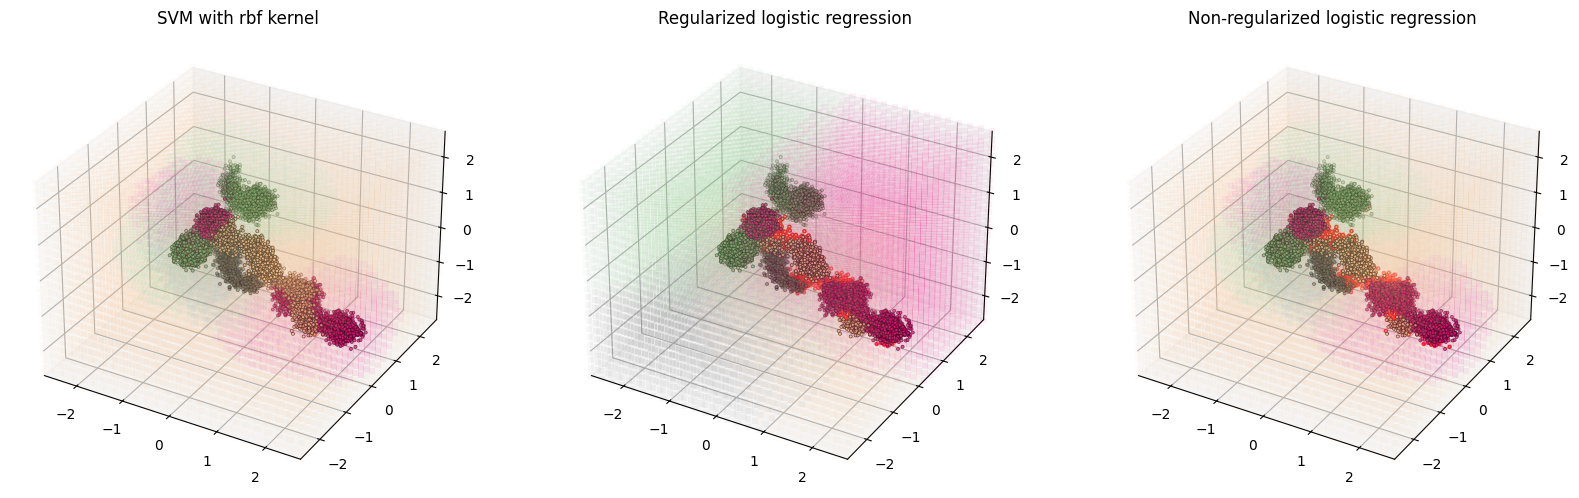

In [23]:
rbf_SVM_grid = best_svm.predict(x_grid) #rbf Kernel
R_logreg_grid = R_logreg.predict(x_grid)      # regularized logistic regression
NR_logreg_grid = NR_logreg.predict(x_grid)    # non-regularized logistic regression

rbf_SVM_m = y_test == rbf_svm_test
R_logreg_m = y_test == R_logreg_test
NR_logreg_m = y_test == NR_logreg_test

fig = plt.figure(figsize=(20,36))
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection="3d")

# Scatter plot 1: SVM with rbf kernel
ax1.set_title("SVM with rbf kernel")
ax1.scatter(x_grid[:,0], x_grid[:,1], x_grid[:,2], c=rbf_SVM_grid, linewidth=0, marker="s", alpha=.05,cmap='Accent')

ax1.scatter(X_test[rbf_SVM_m,0], X_test[rbf_SVM_m,1], X_test[rbf_SVM_m,2], c=y_test[rbf_SVM_m], linewidth=.5, edgecolor="k", marker=".",cmap='Accent')
ax1.scatter(X_test[~rbf_SVM_m,0], X_test[~rbf_SVM_m,1], X_test[~rbf_SVM_m,2], c=y_test[~rbf_SVM_m], linewidth=1, edgecolor="r", marker=".",cmap='Accent')
ax1.set_xlim([-x_max, x_max])
ax1.set_ylim([-x_max, x_max])
ax1.set_zlim([-x_max, x_max])

# Scatter plot 2: regularized logistic regression

ax2.set_title("Regularized logistic regression")
ax2.scatter(x_grid[:,0], x_grid[:,1], x_grid[:,2], c=R_logreg_grid, linewidth=0, marker="s", alpha=.05,cmap='Accent')

ax2.scatter(X_test[R_logreg_m,0], X_test[R_logreg_m,1], X_test[R_logreg_m,2], c=y_test[R_logreg_m], linewidth=.5, edgecolor="k", marker=".",cmap='Accent')
ax2.scatter(X_test[~R_logreg_m,0], X_test[~R_logreg_m,1], X_test[~R_logreg_m,2], c=y_test[~R_logreg_m], linewidth=1, edgecolor="r", marker=".",cmap='Accent')
ax2.set_xlim([-x_max, x_max])
ax2.set_ylim([-x_max, x_max])
ax2.set_zlim([-x_max, x_max])

# Scatter plot 3: non-regularized logistic regression
ax3.set_title("Non-regularized logistic regression")
ax3.scatter(x_grid[:,0], x_grid[:,1], x_grid[:,2], c=rbf_SVM_grid, linewidth=0, marker="s", alpha=.05,cmap='Accent')

ax3.scatter(X_test[NR_logreg_m,0], X_test[NR_logreg_m,1], X_test[NR_logreg_m,2], c=y_test[NR_logreg_m], linewidth=.5, edgecolor="k", marker=".",cmap='Accent')
ax3.scatter(X_test[~NR_logreg_m,0], X_test[~NR_logreg_m,1], X_test[~NR_logreg_m,2], c=y_test[~NR_logreg_m], linewidth=1, edgecolor="r", marker=".",cmap='Accent')
ax3.set_xlim([-x_max, x_max])
ax3.set_ylim([-x_max, x_max])
ax3.set_zlim([-x_max, x_max])

### TO DO (C.Q1) [Answer the following]**

Compare and discuss the results from SVM with m=600 and with m=10000 (or whatever value you set) training data points. If you stopped the SVM, include such aspect in your comparison.

**ANSWER C.Q1:** I ran two trainings, one with m=900 and the other with m=10000.

The first experiment yelded a training error around 0.7% and a test error of 1%.
The second one gave a training error around 1.1% and a test error of 1.3%.

So the errors were lower in the first case, but the second is more significant (in particular the test error didn't increase significantly against a training set ten times bigger), since we have more training data and it is more common in real-word applications to have a training set larger than the test set (m_test=5000).

### TO DO (C.1)

Plot the confusion matrix for the SVM classifier. The confusion matrix has one column for each predicted label and one row for each true label. 
It shows for each class in the corresponding row how many samples belonging to that class gets each possible output label. Notice that the diagonal contains the correctly classified samples, while the other cells correspond to errors. You can obtain it with the sklearn.metrics.confusion_matrix function (see the documentation). You can also print also the normalized confusion matrix.


In [24]:
np.set_printoptions(precision=2, suppress=True) # for better aligned printing of confusion matrix use floatmode='fixed'

u, counts = np.unique(y_test, return_counts=True)
print("Labels and frequencies in test set: ", counts)

#confusion_SVM = skm.confusion_matrix(u,u_pred) # ADD YOUR CODE
confusion_SVM = skm.confusion_matrix(y_test,rbf_svm_test) # ADD YOUR CODE
print("\n Confusion matrix SVM  \n \n", confusion_SVM)
print("\n Confusion matrix SVM (normalized)   \n \n", confusion_SVM /counts[:,None] )

Labels and frequencies in test set:  [5714 2342 5181  862]

 Confusion matrix SVM  
 
 [[5714    0    0    0]
 [   0 2259   82    1]
 [   0   72 5109    0]
 [   0    5    0  857]]

 Confusion matrix SVM (normalized)   
 
 [[1.   0.   0.   0.  ]
 [0.   0.96 0.04 0.  ]
 [0.   0.01 0.99 0.  ]
 [0.   0.01 0.   0.99]]


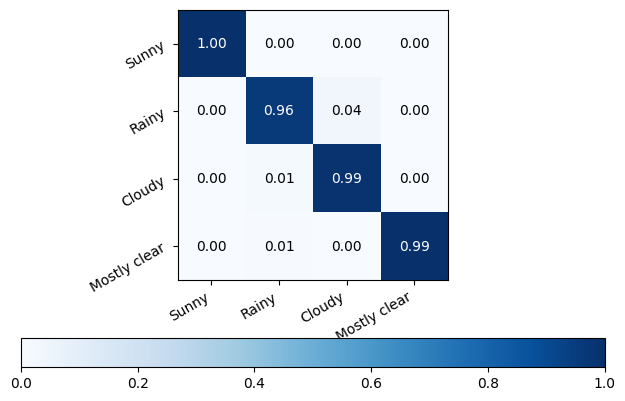

In [25]:
fig = plt.figure()
    
im = plt.imshow(confusion_SVM /counts[:,None], cmap="Blues",interpolation='nearest')
plt.xticks([0,1,2,3], ['Sunny', 'Rainy','Cloudy', 'Mostly clear'],ha="right",rotation=30)
plt.yticks([0,1,2,3], ['Sunny', 'Rainy','Cloudy', 'Mostly clear'],ha="right",rotation=30)
cm = confusion_SVM /counts[:,None]
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(im, location='bottom')  
plt.show()

### TO DO (C.Q2) [Answer the following]

Have a look at the confusion matrix and comment on the obtained accuracies. Why some classes have lower accuracies and others an higher one? Make some guesses on the possible causes.

**ANSWER C.Q2:** Looking at the confusion matrix we can observe that the classification was successful (in fact the accuracy for each weather condition is greater or equal to 95%), but for the "Sunny" and "Mostly clear" classes none or a very low percentage of samples have been misclassified.

It may be that "Sunny" and "Mosly clear" data tend to be distributed in the feature space in a way that makes more easy to separate them (i.e. iSee sensors monitor temperature, pressure and humidity. Those conditions are more similar in "Rainy" and "Cloudy" conditions than in the other cases). However only 5% of rainy data has been classified as Cloudy and only 1% of Cloudy data has been classified as Rainy.